In [1]:
%matplotlib inline

import networkx as nx
from networkx.algorithms import community, bridges, smallworld
import numpy as np
import matplotlib.pyplot as plt

import collections

from scipy import stats, special

import imageio

import time

from IPython.display import Image

import copy

from tqdm import tnrange, tqdm_notebook

np.random.seed(0)

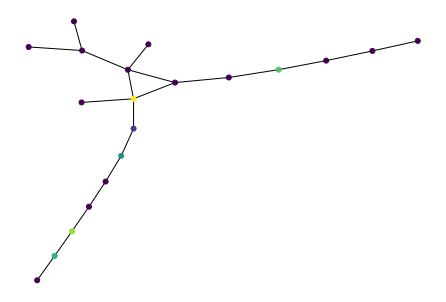

In [2]:
lower = 0
upper = 10
mu = upper / 2
sigma = np.sqrt(mu) / 2

thresh = 0.95

prob_adopted = 0.35

neighbor_threshold = 0.4

product_adoption_jitter = sigma

make_gif = False

calc_omega = False

iters = 500

ims = []

product_dist = stats.truncnorm((lower - mu)/sigma, (upper - mu)/sigma, loc=mu, scale=sigma)
# schelling_dist = stats.truncnorm((0 - 0.5)/0.15, (1 - 0.5)/0.15, loc=0.5, scale=0.25)

def random_product():
    return np.random.choice([np.random.rand()*upper, -1], p=[prob_adopted, 1 - prob_adopted])

def gauss_random_product():
    return np.random.choice([product_dist.rvs(), -1], p=[prob_adopted, 1 - prob_adopted])

def random_schelling():
    return np.random.rand() / 12

init = 20

G = nx.connected_watts_strogatz_graph(init, 3, np.random.rand())

products = dict([(i, random_product()) for i in range(init)])
thresholds = dict([(i, np.random.rand()) for i in range(init)])
schellings = dict([(i, random_schelling()) for i in range(init)])

nx.set_node_attributes(G, products, 'apt_markakis')
nx.set_node_attributes(G, thresholds, 'threshold')
nx.set_node_attributes(G, schellings, 'schelling')

attrs = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in G]

nx.draw_kamada_kawai(G, node_color=attrs, node_size=25)

In [3]:
def barabasi_step(graph):
    for _ in range(np.random.choice(3, p=[0.6, 0.3, 0.1])):
        tot = graph.number_of_edges() * 2
        probs = [val / tot for (_, val) in graph.degree()]
        rands = np.random.uniform(size=len(probs))
        check = [rands[i] <= probs[i] for i in range(len(probs))]
        while not True in check:
            rands = np.random.uniform(size=len(probs))
            check = [rands[i] <= probs[i] for i in range(len(probs))]
        new_prod = random_product()
        graph.add_node(len(rands), apt_markakis = new_prod, schelling = random_schelling(), threshold=np.random.rand())
        graph.add_edges_from([(len(rands), i) for i in range(len(rands)) if check[i]])
    
def threshold_met(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node]]
    if neighbors:
        return (sum([1 for x in neighbors if x > -1]) / len(neighbors)) > graph.node[node]['threshold']
    return False
    
def apt_markakis_step_med(graph):
    unset = [x for x in graph.nodes if graph.node[x]['apt_markakis'] < 0]
    candidates = [x for x in unset if threshold_met(graph, x)]
    if candidates:
        tar = np.random.choice(candidates)
        neighbor_med = np.median([graph.node[x]['apt_markakis'] for x in graph.nodes if graph.node[x]['apt_markakis'] > -1])
        adopted = np.random.normal() * product_adoption_jitter + neighbor_med
        while adopted < 0:
            adopted = np.random.normal() * product_adoption_jitter + neighbor_med
        graph.node[tar]['apt_markakis'] = adopted
    
def apt_markakis_step_avg(graph):
    unset = [x for x in graph.nodes if graph.node[x]['apt_markakis'] < 0]
    candidates = [x for x in unset if threshold_met(graph, x)]
    if candidates:
        tar = np.random.choice(candidates)
        neighbor_avg = np.average([graph.node[x]['apt_markakis'] for x in graph.nodes if graph.node[x]['apt_markakis'] > -1])
        adopted = np.random.normal() * product_adoption_jitter + neighbor_avg
        while adopted < 0:
            adopted = np.random.normal() * product_adoption_jitter + neighbor_avg
        graph.node[tar]['apt_markakis'] = adopted
        
def unhappy(graph, node):
    neighbors = [graph.node[x]['apt_markakis'] for x in graph[node] if graph.node[x]['apt_markakis'] > -1]
    if not neighbors:
        return False
    dif_neighbors = [x for x in neighbors if np.abs(graph.node[node]['apt_markakis'] - x) / graph.node[node]['apt_markakis'] > neighbor_threshold]
    return len(dif_neighbors) / len(neighbors) > graph.node[node]['schelling']

def similar(graph, tar, x):
    if graph.node[x]['apt_markakis'] == -1:
        return False
    return np.abs(graph.node[tar]['apt_markakis'] - graph.node[x]['apt_markakis']) / graph.node[tar]['apt_markakis'] > neighbor_threshold
                
def improved_schelling(graph, n):
    adopted = [x for x in graph.nodes if graph.node[x]['apt_markakis'] > -1]
    candidates = [x for x in adopted if unhappy(graph, x)]
    if not candidates:
        return
    tar = np.random.choice(candidates)
    similar_nodes = [x for x in graph.nodes if similar(graph, tar, x)]
    second_similar = [list(graph.adj[x]) for x in similar_nodes]
    second_similar = [x for y in second_similar for x in y]
    second_similar = similar_nodes
    adds = np.random.choice(second_similar, n)
    for add in adds:
        if not graph.has_edge(tar, add):
            graph.add_edge(tar, add)
            
        if not unhappy(graph, tar):
            break
    
def draw_attrs(graph):
    attrs = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in G.nodes]
    nx.draw_kamada_kawai(G, node_color=attrs, node_size=25)
    
def both_set(graph, x, y):
    return graph.node[x]['apt_markakis'] > -1 and graph.node[y]['apt_markakis'] > -1
    
def edge_decay(graph):
    tot = graph.number_of_edges() * 2
    probs1 = [G.degree[x] + G.degree[y] for (x, y) in graph.edges()]
    probs1 = np.array(probs1)
    probs1 = np.exp(probs1)
    probs1 /= probs1.sum(axis=0)
    
    probs2 = [np.abs(graph.node[x]['apt_markakis'] - graph.node[y]['apt_markakis']) if both_set(graph, x, y) else 0 for (x, y) in graph.edges()]
    probs2 = np.array(probs2)
    probs2 = np.exp(probs2)
    probs2 /= probs2.sum(axis=0)
    
    rands = np.random.beta(0.25, 1.25, len(probs1))
    init_edges = copy.deepcopy(graph.edges())
    bs = list(bridges(graph))
    
    for i, edge in enumerate(init_edges):

        if (rands[i] > probs2[i] and rands[i] > probs1[i]) and not (edge[0], edge[1]) in bs and not (edge[1], edge[0]) in bs:
            graph.remove_edge(edge[0], edge[1])
            bs = list(bridges(graph))

In [4]:
for i in tnrange(iters, desc='executing model'):
    if make_gif:
        draw_attrs(G)
        fname = "images/frames/j_model" + str(i) + ".png"
        plt.savefig(fname)
        ims.append(fname)
        plt.cla()
        plt.clf()
        
    if i%1000 == 0:
        edge_decay(G)
    barabasi_step(G)
    apt_markakis_step_med(G)
    improved_schelling(G, 10)


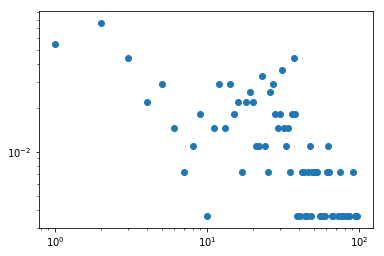

In [5]:
degree_sequence = [d for (n, d) in G.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

tot = sum(cnt)
per = [c / tot for c in cnt]

plt.xscale('log')
plt.yscale('log')
plt.scatter(deg, per)

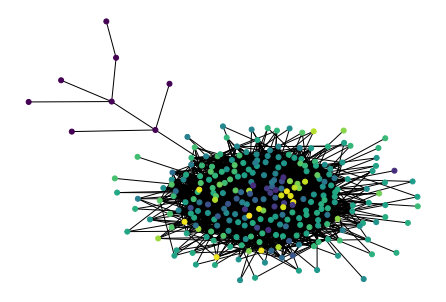

In [6]:
draw_attrs(G)
fname = "images/frames/final" + str(int(time.time())) + '.png'
plt.savefig(fname)

if make_gif:
    ims.append(fname)

    files = []
    for im in ims:
        files.append(imageio.imread(im))

    gif_name = 'images/runs/' + str(int(time.time())) + '.gif'
    imageio.mimsave(gif_name, files, duration=0.3)
    
    with open(gif_name,'rb') as f:
        display(Image(data=f.read(), format='png'))

In [7]:
# communities = list(range(1,11))
# vals = []

# for i in communities:
#     temp = []
#     for _ in range(15):
#         c = list(community.asyn_fluidc(G, i))
#         temp.append(community.performance(G, c) + community.coverage(G, c))
#     vals.append(np.average(temp))
#     print(i, vals[-1])

# vals = list(np.around(np.array(vals), 1))
    
# print(communities)
# print(vals)
# print(vals.index(max(vals)))

In [8]:
# c = list(community.asyn_fluidc(G, vals.index(max(vals)) + 1))

# for com in c:
#     attrs = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in com]
#     if len([x for x in attrs if x > -1]) > 0:
#         print(com, len(com), np.average([x for x in attrs if x >-1]))
#     else:
#         print(com, 0)
#     nx.draw(G.subgraph(com), node_color=attrs, node_size=25)
#     plt.show()

# print(len(c))

In [9]:
# for com1 in c:
#     for com2 in c:
#         attrs1 = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in com1]
#         attrs2 = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in com2]
#         if len([x for x in attrs1 if x > -1]) > 0 and len([x for x in attrs2 if x > -1]) > 0:
#             print(np.average([x for x in attrs1 if x >-1]), np.average([x for x in attrs2 if x >-1]))
#         else:
#             print(0, 0)
            
#         union = com1.union(com2)
#         attrsu = [nx.get_node_attributes(G, 'apt_markakis')[i] for i in union]
#         nx.draw(G.subgraph(union), node_color=attrsu, node_size=25)
#         plt.show()

In [10]:
if calc_omega:
    omega = smallworld.omega(G)
    print(omega)